In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/physionet-ecg-image-digitization/sample_submission.parquet
/kaggle/input/physionet-ecg-image-digitization/train.csv
/kaggle/input/physionet-ecg-image-digitization/test.csv
/kaggle/input/physionet-ecg-image-digitization/test/2352854581.png
/kaggle/input/physionet-ecg-image-digitization/test/1053922973.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0005.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0006.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0011.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0004.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893.csv
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0012.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0003.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0001.png
/kaggle/input/physionet-ecg-i

Possible input roots found: ['/kaggle/input/physionet-ecg-image-digitization']
train.csv found at: /kaggle/input/physionet-ecg-image-digitization/train.csv
test.csv found at: /kaggle/input/physionet-ecg-image-digitization/test.csv

---- train.csv head ----
         id    fs  sig_len
0   7663343   500     5000
1  10140238  1000    10000
2  11842146  1000    10000
3  19030958   250     2500
4  19585145   512     5120

train.csv shape: (977, 3)
Unique sampling frequencies in train: [250, 256, 500, 512, 1000, 1025]
sig_len stats (min,max,mean): 2500 10250 5900.5527123848515

---- test.csv head ----
           id lead    fs  number_of_rows
0  1053922973    I  1000            2500
1  1053922973   II  1000           10000
2  1053922973  III  1000            2500
3  1053922973  aVR  1000            2500
4  1053922973  aVL  1000            2500

test.csv shape: (24, 4)
Unique number_of_rows: [2500, 10000]

Sample train id chosen: 1949321289
Found 9 png(s) and 1 csv(s) for id 1949321289
First fe

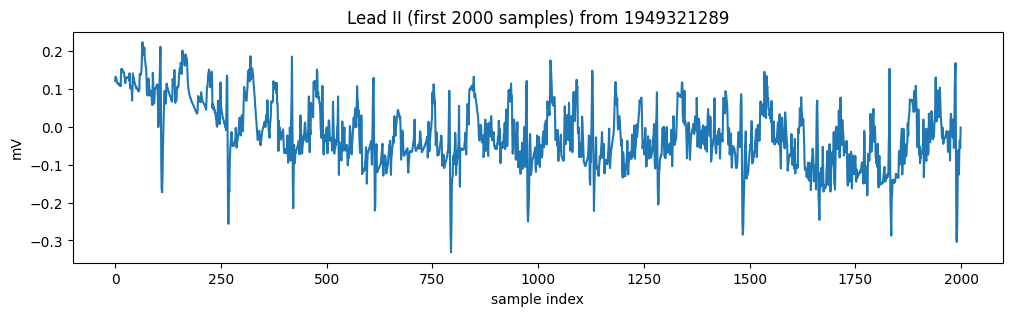


Displaying image: /kaggle/input/physionet-ecg-image-digitization/train/1949321289/1949321289-0012.png


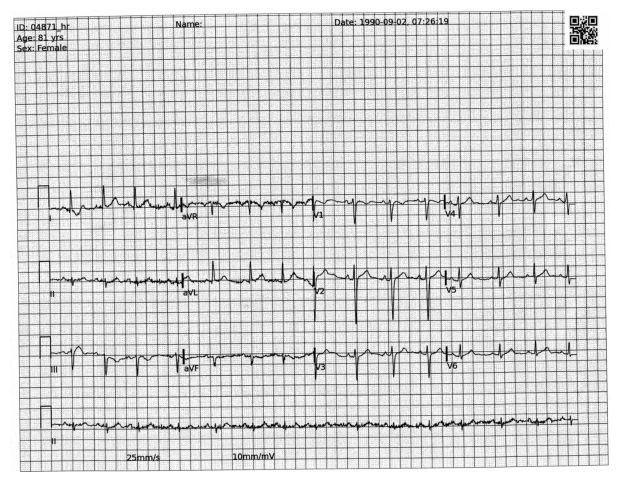

In [2]:
# STEP 1: Basic EDA
import os, glob, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) locate the competition root under /kaggle/input
base_paths = [p for p in glob.glob('/kaggle/input/*') if os.path.isdir(p)]
print("Possible input roots found:", base_paths)

# Try to find train.csv and test.csv automatically
train_csv_paths = glob.glob('/kaggle/input/**/train.csv', recursive=True)
test_csv_paths = glob.glob('/kag.glob.glob/**/test.csv', recursive=True) if False else glob.glob('/kaggle/input/**/test.csv', recursive=True)

if len(train_csv_paths)==0 or len(test_csv_paths)==0:
    print("Did not find train.csv or test.csv automatically. Listing top-level '/kaggle/input' for you again:")
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames[:5]:
            print(os.path.join(dirname, filename))
else:
    train_csv = train_csv_paths[0]
    test_csv = test_csv_paths[0]
    print("train.csv found at:", train_csv)
    print("test.csv found at:", test_csv)

    # 2) read metadata
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    print("\n---- train.csv head ----")
    print(train_df.head())
    print("\ntrain.csv shape:", train_df.shape)
    print("Unique sampling frequencies in train:", sorted(train_df['fs'].unique()))
    print("sig_len stats (min,max,mean):", train_df['sig_len'].min(), train_df['sig_len'].max(), train_df['sig_len'].mean())

    print("\n---- test.csv head ----")
    print(test_df.head())
    print("\ntest.csv shape:", test_df.shape)
    if 'number_of_rows' in test_df.columns:
        print("Unique number_of_rows:", sorted(test_df['number_of_rows'].unique()) )

    # 3) pick a sample id from train to inspect files
    sample_id = random.choice(train_df['id'].tolist())
    print("\nSample train id chosen:", sample_id)

    # try to find files under any folder containing this id
    candidate_pngs = glob.glob(f"/kaggle/input/**/{sample_id}*.png", recursive=True)
    candidate_csvs = glob.glob(f"/kaggle/input/**/{sample_id}*.csv", recursive=True)
    print(f"Found {len(candidate_pngs)} png(s) and {len(candidate_csvs)} csv(s) for id {sample_id}")

    if len(candidate_pngs)>0:
        print("First few image paths:")
        for p in candidate_pngs[:8]:
            print("  ", p)
    if len(candidate_csvs)>0:
        print("Signal CSV paths (first 5):")
        for p in candidate_csvs[:5]:
            print("  ", p)

    # 4) load the ground-truth CSV for that id (if present) and print info
    gt_csv_path = None
    for p in candidate_csvs:
        if p.endswith(f"{sample_id}.csv"):
            gt_csv_path = p
            break
    if gt_csv_path is None and len(candidate_csvs)>0:
        gt_csv_path = candidate_csvs[0]

    if gt_csv_path:
        print("\nLoading ground-truth CSV:", gt_csv_path)
        sig = pd.read_csv(gt_csv_path)
        print("Signal columns:", sig.columns.tolist())
        print("Signal shape (rows x leads):", sig.shape)
        print("First 5 rows of lead II:")
        print(sig['II'].head().to_list()[:10])
        # Plot lead II
        plt.figure(figsize=(12,3))
        plt.plot(sig['II'].values[:2000])   # show first chunk
        plt.title(f"Lead II (first 2000 samples) from {sample_id}")
        plt.xlabel("sample index"); plt.ylabel("mV")
        plt.show()
    else:
        print("No ground-truth CSV found for this id in the input folders.")

    # 5) Display one PNG image (if available)
    if len(candidate_pngs)>0:
        img_path = candidate_pngs[0]
        print("\nDisplaying image:", img_path)
        img = Image.open(img_path).convert('RGB')
        plt.figure(figsize=(10,6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("No PNG images found for this id.")


In [3]:
# Step 2: Explore the Data
train_df = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/train.csv')
train_df.head()

id    fs  sig_len
0   7663343   500     5000
1  10140238  1000    10000
2  11842146  1000    10000
3  19030958   250     2500
4  19585145   512     5120

In [4]:
# Step 3: Understanding The Dataset

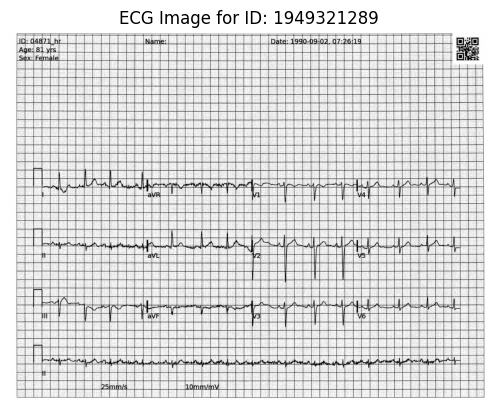

In [4]:
# Step 4: Explore One Example in Detail
# import matplotlib.pyplot as plt
import cv2

# Pick a sample id (printed one earlier)
sample_id = 1949321289

# Read a sample image
img_path = f'/kaggle/input/physionet-ecg-image-digitization/train/{sample_id}/{sample_id}-0004.png'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display it
plt.imshow(img_rgb)
plt.title(f"ECG Image for ID: {sample_id}")
plt.axis('off')
plt.show()


       I     II    III  aVR  aVL  aVF  V1  V2  V3  V4  V5  V6
0 -0.083  0.121  0.204  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
1 -0.079  0.132  0.212  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
2 -0.078  0.129  0.207  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
3 -0.092  0.127  0.219  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
4 -0.112  0.117  0.230  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


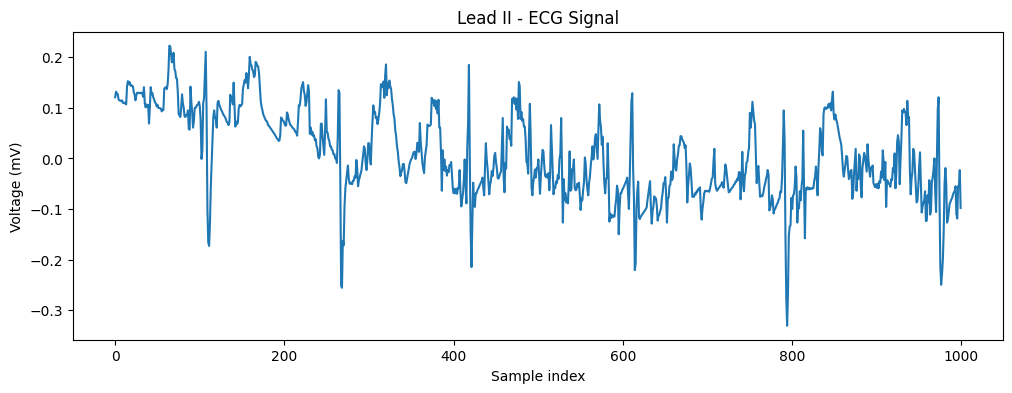

In [5]:
# Step 5: Load and Visualize the True ECG Signal (from CSV)
# Load the ground truth ECG data (time series)
csv_path = f'/kaggle/input/physionet-ecg-image-digitization/train/{sample_id}/{sample_id}.csv'
signal_df = pd.read_csv(csv_path)

# Show the first few rows
print(signal_df.head())

# Plot one of the leads, e.g., 'II'
plt.figure(figsize=(12, 4))
plt.plot(signal_df['II'][:1000])  # plot first 1000 points
plt.title('Lead II - ECG Signal')
plt.xlabel('Sample index')
plt.ylabel('Voltage (mV)')
plt.show()

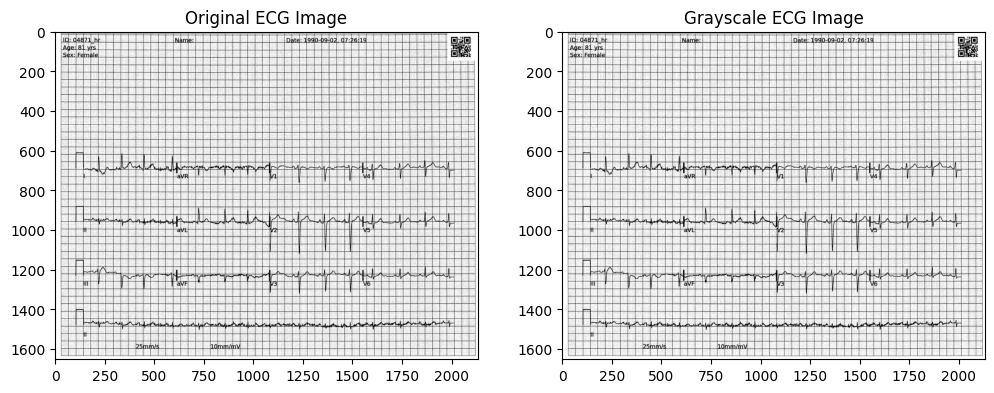

In [6]:
# Step 6: Understand the Task Before Modeling
# Step 6.1: Preprocess ECG images
# import cv2
# import matplotlib.pyplot as plt

# Pick one ECG image
img_path = f'/kaggle/input/physionet-ecg-image-digitization/train/{sample_id}/{sample_id}-0004.png'

# Read the image
img = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show both color and grayscale
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original ECG Image")

plt.subplot(1,2,2)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale ECG Image")
plt.show()

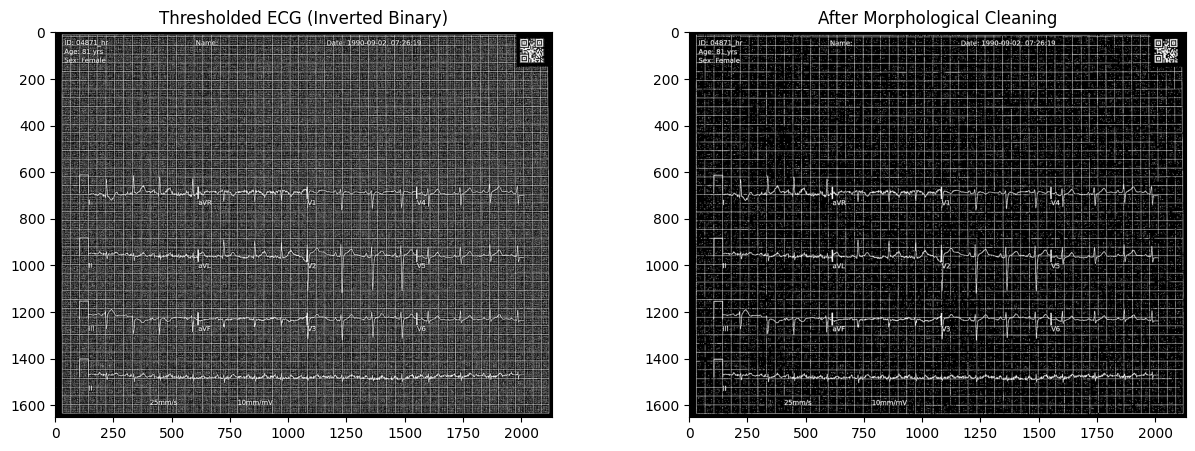

In [7]:
# Step 6.1.1: Apply Thresholding or Edge Detection
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(
    gray, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV, 
    15, 
    8
)

# Optional: clean small noise using morphological operations
kernel = np.ones((2, 2), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Show the results
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(thresh, cmap='gray')
plt.title("Thresholded ECG (Inverted Binary)")

plt.subplot(1,2,2)
plt.imshow(clean, cmap='gray')
plt.title("After Morphological Cleaning")
plt.show()

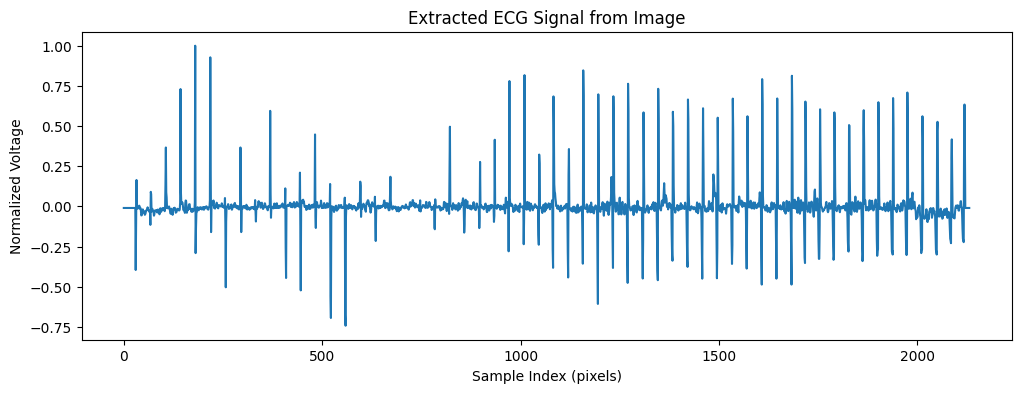

In [8]:
# Step 6.2 — Pixel-to-Signal Mapping
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt

# Convert cleaned image to binary (ensure it's 0 and 1)
binary = (clean < 128).astype(np.uint8)

# For each x-column, find the y-position of the ECG line (mean or median of white pixels)
y_positions = []
for x in range(binary.shape[1]):
    ys = np.where(binary[:, x] == 1)[0]
    if len(ys) > 0:
        y_positions.append(np.median(ys))
    else:
        y_positions.append(np.nan)

y_positions = np.array(y_positions)

# Normalize and invert (since higher y = lower amplitude)
signal_from_image = -(y_positions - np.nanmean(y_positions))
signal_from_image = signal_from_image / np.nanmax(np.abs(signal_from_image))

# Plot the extracted waveform
plt.figure(figsize=(12, 4))
plt.plot(signal_from_image)
plt.title("Extracted ECG Signal from Image")
plt.xlabel("Sample Index (pixels)")
plt.ylabel("Normalized Voltage")
plt.show()

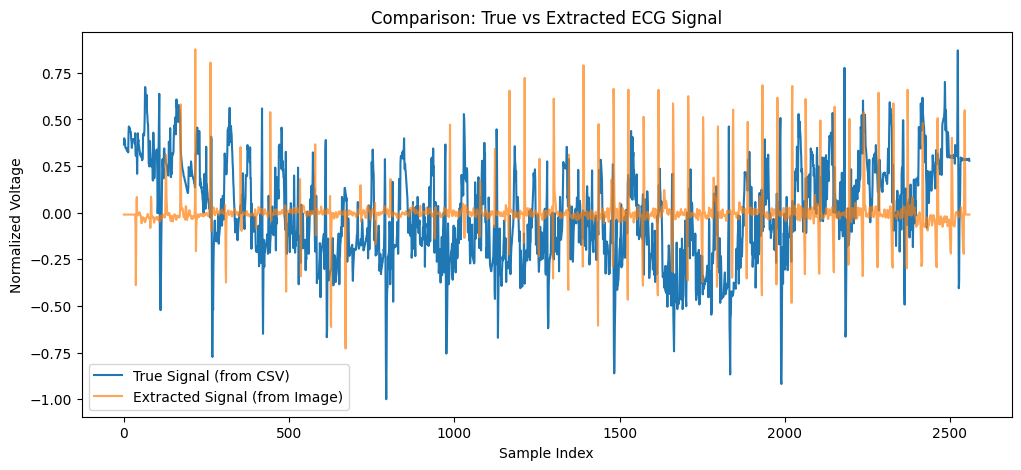

In [9]:
# Step 6.3 — Pairing the Extracted Signal with the True Numeric Signal
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# Load the true ECG signal from the CSV for the same sample_id
csv_path = f'/kaggle/input/physionet-ecg-image-digitization/train/{sample_id}/{sample_id}.csv'
true_signal = pd.read_csv(csv_path)

# Select one lead, e.g., Lead II (or whichever column has values)
lead_name = 'II'
true_signal_values = true_signal[lead_name].dropna().values

# Normalize both signals for comparison
true_signal_values = true_signal_values / np.max(np.abs(true_signal_values))
image_signal_resized = np.interp(
    np.linspace(0, len(signal_from_image)-1, len(true_signal_values)),
    np.arange(len(signal_from_image)),
    signal_from_image
)

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(true_signal_values, label="True Signal (from CSV)")
plt.plot(image_signal_resized, label="Extracted Signal (from Image)", alpha=0.7)
plt.title("Comparison: True vs Extracted ECG Signal")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.show()

In [10]:
# Aliases for Step 6.4
extracted_signal = image_signal_resized
true_signal = true_signal_values

2025-11-13 05:01:48.143009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763010108.335255      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763010108.386278      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763010119.893267      39 gpu_device.cc:2022] Created device /job:localhost/repl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2560, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2560, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2560, 1)        │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1763010122.621311     109 service.cc:148] XLA service 0x7928c800b140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763010122.621878     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763010122.826315     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763010124.017645     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


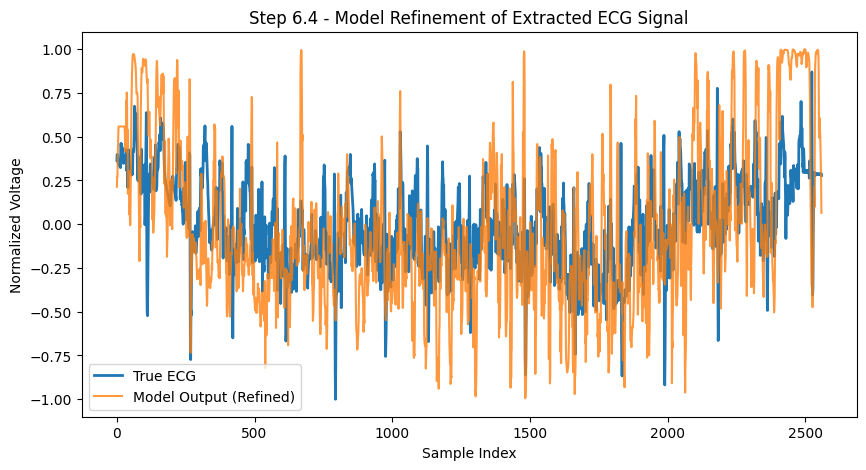

In [11]:
# Step 6.4 – Learning Model to Refine Extracted ECG
# import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Prepare Data
X = extracted_signal.reshape(-1, 1)  # input: from image
y = true_signal[:len(extracted_signal)].reshape(-1, 1)  # target: from CSV

# normalize (optional)
X = (X - np.mean(X)) / np.std(X)
y = (y - np.mean(y)) / np.std(y)

# reshape for CNN
X = np.expand_dims(X, axis=0)  # (1, samples, 1)
y = np.expand_dims(y, axis=0)

# 2. Define Model
model = models.Sequential([
    layers.Conv1D(32, 5, activation='relu', padding='same', input_shape=(X.shape[1], 1)),
    layers.Conv1D(64, 5, activation='relu', padding='same'),
    layers.Conv1D(1, 5, activation='tanh', padding='same')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# 3. Train
history = model.fit(X, y, epochs=200, verbose=0)

# 4. Predict
predicted = model.predict(X)[0].flatten()

# 5. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(true_signal[:len(predicted)], label='True ECG', linewidth=2)
plt.plot(predicted, label='Model Output (Refined)', alpha=0.8)
plt.legend()
plt.title('Step 6.4 - Model Refinement of Extracted ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Voltage')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
# Ensure prediction and true labels have the same shape
y_pred = model.predict(X)

# Flatten both arrays
y_pred = y_pred.flatten()
y_true = y.flatten() if len(y.shape) > 1 else y

# Make them the same length
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

# Compute MSE
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Squared Error (MSE): 0.676291


Mean Squared Error (MSE): 0.676291
Signal-to-Noise Ratio (SNR): 1.70 dB


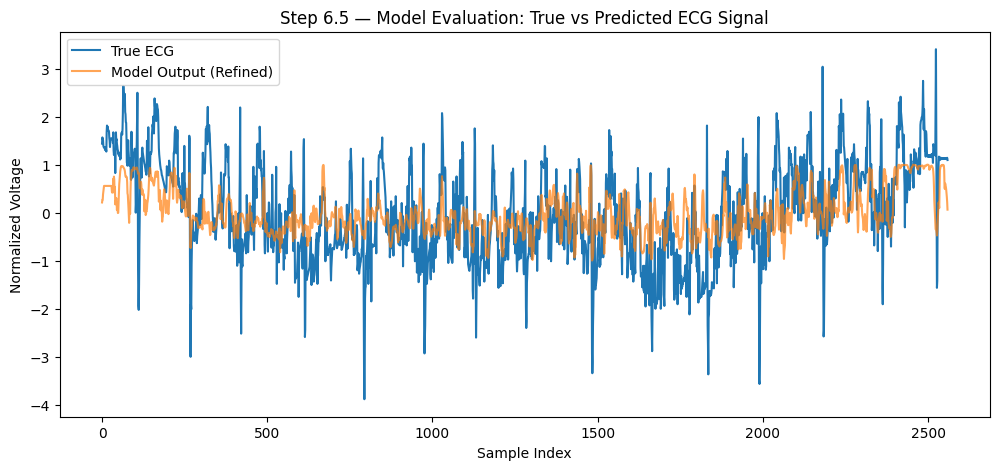

In [13]:
# Step 6.5 — Evaluate Model Performance
import numpy as np
import matplotlib.pyplot as plt

# Flatten y_true and y_pred for consistent shape
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_true_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse:.6f}")

# Compute Signal-to-Noise Ratio (SNR)
signal_power = np.mean(np.square(y_true_flat))
noise_power = np.mean(np.square(y_true_flat - y_pred_flat))
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")

# Visual comparison
plt.figure(figsize=(12,5))
plt.plot(y_true_flat, label="True ECG")
plt.plot(y_pred_flat, label="Model Output (Refined)", alpha=0.7)
plt.title("Step 6.5 — Model Evaluation: True vs Predicted ECG Signal")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.show()

Processing sample_id = 1949321289
Sampling frequency (fs): 256
Using lead: II
True signal length: 2560
Using image: /kaggle/input/physionet-ecg-image-digitization/train/1949321289/1949321289-0012.png
Raw image-derived signal length (pixels): 2144
Lag used (samples): 14 which is 0.0546875 seconds
Baseline aligned SNR (after filtering & alignment): -2.687 dB


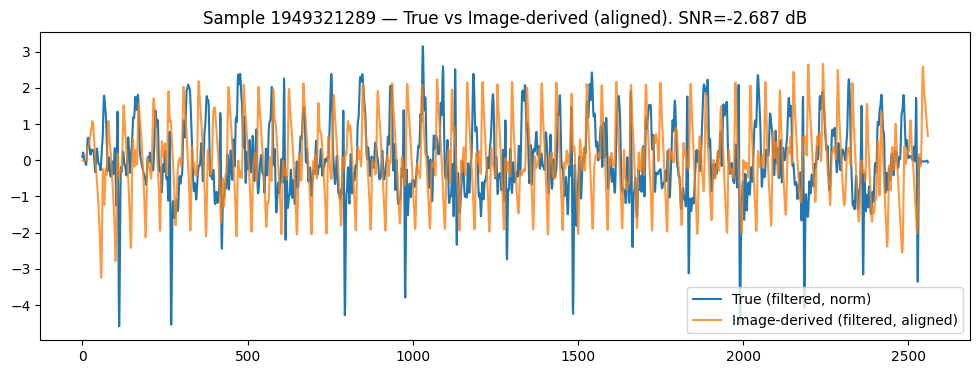

Prepared keys: ['sample_id', 'fs', 'lead', 'true_norm', 'img_aligned', 'snr_db']


(array([ 0.08909441,  0.18083845,  0.21433804, ..., -0.01350235,
        -0.02953314, -0.05503946]),
 array([0.        , 0.        , 0.        , ..., 0.85319008, 0.76197177,
        0.67045805]),
 256,
 'II',
 1949321289,
 -2.6870939907732)

In [14]:
# Step 7.1 — Data preparation & alignment (per-record)
from scipy.signal import butter, filtfilt, resample

# --- Helpers ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def align_signals_with_maxlag(sig_true, sig_pred, fs, max_shift_seconds=0.2):
    # returns: shifted_pred, lag_used (in samples). Positive lag means pred shifts right (delayed).
    maxlag = int(round(max_shift_seconds * fs))
    # handle NaNs in pred by zero-filling
    sig_pred_clean = np.copy(sig_pred)
    sig_pred_clean[np.isnan(sig_pred_clean)] = 0.0
    # cross-correlation
    corr = np.correlate(sig_true - np.mean(sig_true), sig_pred_clean - np.mean(sig_pred_clean), mode='full')
    lags = np.arange(-len(sig_pred_clean)+1, len(sig_true))
    # find best lag but restrict to [-maxlag, +maxlag]
    center = len(corr)//2
    window_idx = np.where((lags >= -maxlag) & (lags <= maxlag))[0]
    if len(window_idx)==0:
        best_idx = np.argmax(corr)
    else:
        best_idx = window_idx[np.argmax(corr[window_idx])]
    best_lag = lags[best_idx]
    # shift pred accordingly
    if best_lag > 0:
        shifted = np.concatenate((np.zeros(best_lag), sig_pred_clean[:-best_lag]))
    elif best_lag < 0:
        shifted = np.concatenate((sig_pred_clean[-best_lag:], np.zeros(-best_lag)))
    else:
        shifted = sig_pred_clean
    return shifted, int(best_lag)

# --- Choose a sample (use your current sample_id) ---
# If you restarted kernel, set sample_id explicitly:
# sample_id = 49746380
# Otherwise the variable should already exist. I'll try to read it safely:
try:
    sample_id
except NameError:
    sample_id = int(input("Enter sample_id to process (e.g. 49746380): "))

print("Processing sample_id =", sample_id)

# paths
root = '/kaggle/input/physionet-ecg-image-digitization'
train_csv = os.path.join(root, 'train.csv')
train_df = pd.read_csv(train_csv)
fs = int(train_df.loc[train_df['id'] == sample_id, 'fs'].values[0])
print("Sampling frequency (fs):", fs)

# load true signal
csv_path = glob.glob(os.path.join(root, 'train', str(sample_id), f"{sample_id}.csv"))
if len(csv_path)==0:
    raise FileNotFoundError("Ground-truth CSV not found for this sample_id")
csv_path = csv_path[0]
true_df = pd.read_csv(csv_path)
# choose lead II (good long one)
lead = 'II'
if lead not in true_df.columns:
    # fall back to first non-NaN column
    nonnan_cols = [c for c in true_df.columns if not true_df[c].isna().all()]
    lead = nonnan_cols[0]
print("Using lead:", lead)
true_signal = true_df[lead].dropna().values
sig_len = len(true_signal)
print("True signal length:", sig_len)

# load and extract image-derived signal (reuse your earlier clean/extract code)
# try a few png variants in the folder and pick one available (use -0004 if present)
img_candidates = glob.glob(os.path.join(root, 'train', str(sample_id), f"{sample_id}-*.png"))
if len(img_candidates)==0:
    raise FileNotFoundError("No PNGs found in sample folder")
img_path = img_candidates[0]
print("Using image:", img_path)

# read image, grayscale, threshold & clean (same approach you used)
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 8)
kernel = np.ones((2,2), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# extract column-wise median y position (same approach)
binary = (clean > 0).astype(np.uint8)  # 1 where trace/grid exists
y_positions = []
for x in range(binary.shape[1]):
    ys = np.where(binary[:, x] == 1)[0]
    if len(ys) > 0:
        y_positions.append(np.median(ys))
    else:
        y_positions.append(np.nan)
y_positions = np.array(y_positions)
# invert and normalize
img_signal = -(y_positions - np.nanmean(y_positions))
# replace NaN with linear interpolation
nans = np.isnan(img_signal)
if nans.any():
    img_signal[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), img_signal[~nans])
# normalize to [-1,1]
img_signal = img_signal / np.nanmax(np.abs(img_signal))

print("Raw image-derived signal length (pixels):", len(img_signal))

# Resample image-derived signal to match the number of samples in true_signal
img_len = len(img_signal)
resampled_img_signal = np.interp(
    np.linspace(0, img_len-1, sig_len),
    np.arange(img_len),
    img_signal
)

# Band-pass filter both signals (0.5 - 40 Hz) using the record's fs
lowcut, highcut = 0.5, 40.0
try:
    true_filtered = bandpass_filter(true_signal, lowcut, highcut, fs, order=4)
except Exception as e:
    # if filter fails due to short length, skip filtering
    print("Warning: true signal filtering failed:", e)
    true_filtered = true_signal.copy()

# For the image-resampled signal, we must use the same fs and length. If true length != expected time*fs,
# assume true_signal length is correct and resampled signal already matches it.
try:
    img_filtered = bandpass_filter(resampled_img_signal, lowcut, highcut, fs, order=4)
except Exception as e:
    print("Warning: image signal filtering failed:", e)
    img_filtered = resampled_img_signal.copy()

# Normalize to zero mean (competition removes constant offset anyway)
true_norm = (true_filtered - np.mean(true_filtered)) / (np.std(true_filtered) + 1e-12)
img_norm = (img_filtered - np.mean(img_filtered)) / (np.std(img_filtered) + 1e-12)

# Align image->true using cross-correlation but limit lag to 0.2 seconds (competition rule)
aligned_img, lag_used = align_signals_with_maxlag(true_norm, img_norm, fs, max_shift_seconds=0.2)
print("Lag used (samples):", lag_used, "which is", lag_used / fs, "seconds")

# After alignment, re-normalize amplitude by matching std or scale
scale = (np.std(true_norm) + 1e-12) / (np.std(aligned_img) + 1e-12)
aligned_img = aligned_img * scale

# Compute a baseline SNR between true and aligned image signal
signal_power = np.mean(true_norm**2)
noise_power = np.mean((true_norm - aligned_img)**2)
snr_db = 10 * np.log10(signal_power / (noise_power + 1e-12))
print(f"Baseline aligned SNR (after filtering & alignment): {snr_db:.3f} dB")

# Plot quick comparison
plt.figure(figsize=(12,4))
plt.plot(true_norm, label='True (filtered, norm)')
plt.plot(aligned_img, label='Image-derived (filtered, aligned)', alpha=0.8)
plt.title(f'Sample {sample_id} — True vs Image-derived (aligned). SNR={snr_db:.3f} dB')
plt.legend()
plt.show()

# Save prepared arrays (for next steps)
prepared = {
    'sample_id': sample_id,
    'fs': fs,
    'lead': lead,
    'true_norm': true_norm,
    'img_aligned': aligned_img,
    'snr_db': snr_db
}
print("Prepared keys:", list(prepared.keys()))
# keep variables in notebook for next steps
true_norm, aligned_img, fs, lead, sample_id, snr_db

Enhanced input shape: (10250, 3)


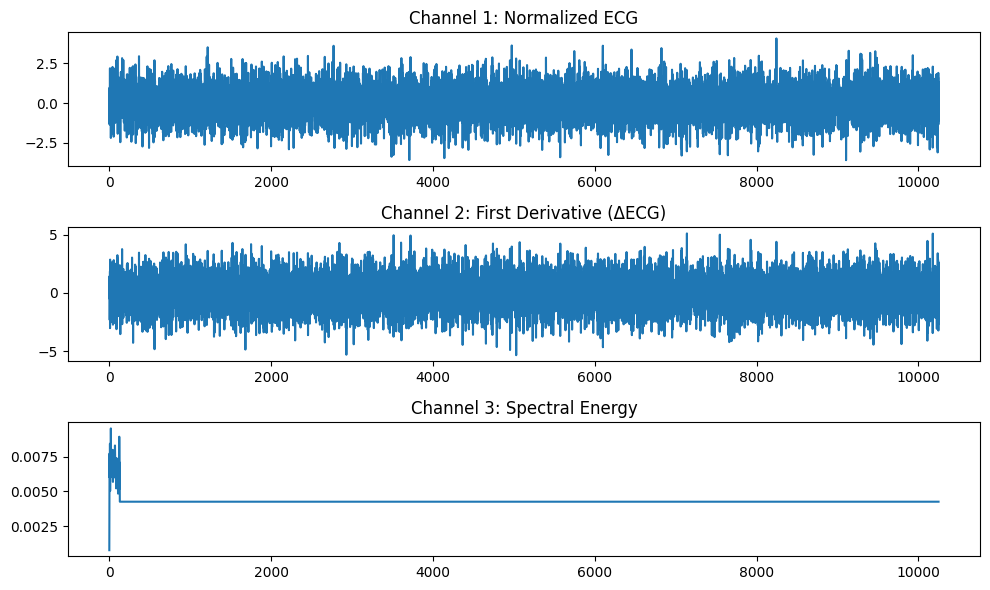

Segmented X: (39, 500, 3), y: (39, 500, 1)
Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - loss: 0.8869 - mean_absolute_error: 0.8161 - val_loss: 0.8449 - val_mean_absolute_error: 0.7908 - learning_rate: 0.0010
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.7621 - mean_absolute_error: 0.7285 - val_loss: 0.8165 - val_mean_absolute_error: 0.7695 - learning_rate: 0.0010
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.7399 - mean_absolute_error: 0.7117 - val_loss: 0.7944 - val_mean_absolute_error: 0.7547 - learning_rate: 0.0010
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.6463 - mean_absolute_error: 0.6412 - val_loss: 0.7784 - val_mean_absolute_error: 0.7437 - learning_rate: 0.0010
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.6273 - mean_absolute_error: 0.6282 - val_loss: 0.7580 - val_mean_absolute_error: 0.7288 - learning_rate: 0.0010
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5710 - mean_absolute_error: 0.5828 - va

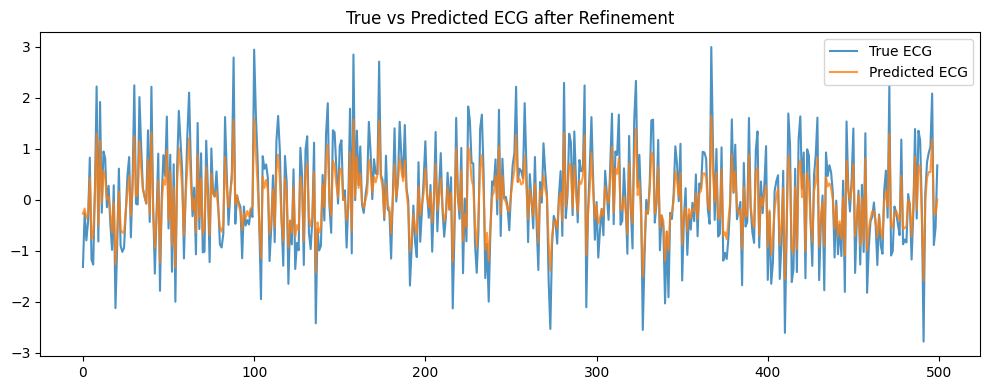

In [17]:
# =========================================================
#  STEP 7.2 — Feature Engineering + Segmentation + Training
# =========================================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# -------------------------------
#   Helper: Add Features
# -------------------------------
# def add_features(ecg_signal):
#     ecg_norm = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)
#     d_ecg = np.gradient(ecg_norm)
#     win = 128
#     spec_energy = np.convolve(ecg_norm**2, np.ones(win)/win, mode='same')
#     X_feat = np.stack([ecg_norm, d_ecg, spec_energy], axis=-1)
#     return X_feat

def add_features(ecg_signal, fs=300, include_spectral=True):
    # import numpy as np
    from scipy.signal import welch

    # Normalize the signal
    ecg_norm = (ecg_signal - np.mean(ecg_signal)) / (np.std(ecg_signal) + 1e-8)

    # Derivative (temporal feature)
    ecg_diff = np.diff(ecg_norm, prepend=ecg_norm[0])

    # Initialize feature list with time-domain features
    features = [ecg_norm, ecg_diff]

    # Optionally add spectral features
    if include_spectral:
        f, Pxx = welch(ecg_norm, fs=fs, nperseg=256)
        # Interpolate to match signal length
        spectral_energy = np.interp(
            np.linspace(0, len(ecg_norm), len(ecg_norm)),
            np.linspace(0, len(Pxx), len(Pxx)),
            Pxx
        )
        features.append(spectral_energy)

    # Stack all features column-wise (shape: T x channels)
    X = np.stack(features, axis=-1)

    return X

# -------------------------------
#   Helper: Segment Signal
# -------------------------------
def segment_signal(X, y, window_size=500, step=250):
    X_segments, y_segments = [], []
    for i in range(0, len(X) - window_size, step):
        X_segments.append(X[i:i+window_size])
        y_segments.append(y[i:i+window_size])
    return np.array(X_segments), np.array(y_segments)

# -------------------------------
#   Build CNN + BiLSTM Model
# -------------------------------
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape, name="ecg_input")

    x = layers.Conv1D(64, 7, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(128, 5, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.TimeDistributed(layers.Dense(1))(x)
    model = models.Model(inputs, outputs, name="CNN_BiLSTM_ECG")
    return model

# -------------------------------
#   Load or Simulate ECG Data
# -------------------------------
# Replace this with your actual data arrays
# Example: aligned_img = predicted_signal_from_phase1, true_norm = true_groundtruth
T = 10250
aligned_img = np.random.randn(T)
true_norm = aligned_img + 0.1 * np.random.randn(T)  # Simulated clean signal

# Normalize both input and target
aligned_img = (aligned_img - np.mean(aligned_img)) / np.std(aligned_img)
true_norm = (true_norm - np.mean(true_norm)) / np.std(true_norm)

# Add derived features
X_feat = add_features(aligned_img)
y = true_norm.reshape(-1, 1)

print(f"Enhanced input shape: {X_feat.shape}")

# Visualize feature channels
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(X_feat[:,0]); ax[0].set_title("Channel 1: Normalized ECG")
ax[1].plot(X_feat[:,1]); ax[1].set_title("Channel 2: First Derivative (ΔECG)")
ax[2].plot(X_feat[:,2]); ax[2].set_title("Channel 3: Spectral Energy")
plt.tight_layout(); plt.show()

# -------------------------------
#   Segment for Training
# -------------------------------
window_size = 500
step = 250
X_segments, y_segments = segment_signal(X_feat, y, window_size, step)
print(f"Segmented X: {X_segments.shape}, y: {y_segments.shape}")

# -------------------------------
#   Compile + Train
# -------------------------------
def hybrid_loss(alpha=0.3):
    def loss_fn(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        return alpha * mse + (1 - alpha) * mae
    return loss_fn

input_shape = X_segments.shape[1:]
model = build_model(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=hybrid_loss(alpha=0.3),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

cb = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_segments, y_segments,
    validation_split=0.2,
    epochs=80,
    batch_size=16,
    callbacks=cb,
    verbose=1
)

# -------------------------------
#   Evaluate + Visualize
# -------------------------------
pred = model.predict(X_segments[:1])
pred_flat = pred.reshape(-1)
true_flat = y_segments[0].reshape(-1)

mse = np.mean((pred_flat - true_flat) ** 2)
snr = 10 * np.log10(np.var(true_flat) / np.var(true_flat - pred_flat))
print(f"\nMSE: {mse:.4f}, SNR: {snr:.2f} dB")

plt.figure(figsize=(10, 4))
plt.plot(true_flat, label="True ECG", alpha=0.8)
plt.plot(pred_flat, label="Predicted ECG", alpha=0.8)
plt.title("True vs Predicted ECG after Refinement")
plt.legend(); plt.tight_layout(); plt.show()

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Timesteps T = 10250
X_feat shape (timesteps, channels): (10250, 3)
X shape: (1, 10250, 3) y shape: (1, 10250, 1)


Model: "CNN_BiLSTM_ECG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ecg_input (InputLayer)          │ (None, 10250, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 10250, 32)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10250, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 10250, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10250, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10250, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10250, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 10250, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10250, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 10250, 64)      │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10250, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 10250, 32)      │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10250, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ecg_out (TimeDistributed)       │ (None, 10250, 1)       │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,337 (165.38 KB)

 Trainable params: 42,145 (164.63 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10

Epoch 1: loss improved from inf to 1.30725, saving model to /kaggle/working/best_ecg_model.h5
1/1 - 1083s - 1083s/step - loss: 1.3073 - mean_absolute_error: 0.8196 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: loss improved from 1.30725 to 1.28383, saving model to /kaggle/working/best_ecg_model.h5
1/1 - 1s - 1s/step - loss: 1.2838 - mean_absolute_error: 0.8120 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: loss improved from 1.28383 to 1.27547, saving model to /kaggle/working/best_ecg_model.h5
1/1 - 1s - 1s/step - loss: 1.2755 - mean_absolute_error: 0.8080 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: loss improved from 1.27547 to 1.25552, saving model to /kaggle/working/best_ecg_model.h5
1/1 - 1s - 1s/step - loss: 1.2555 - mean_absolute_error: 0.8016 - learning_rate: 1.0000e-04
Epoch 5/10

Epoch 5: loss improved from 1.25552 to 1.24326, saving model to /kaggle/working/best_ecg_model.h5
1/1 - 1s - 1s/step - loss: 1.2433 - mean_absolute_error: 0.7979 - learning_rate:

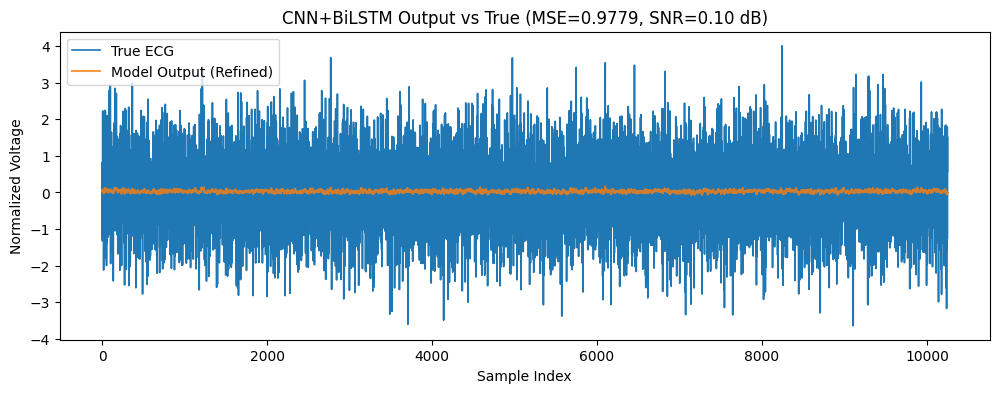

✅ Training and plotting complete!


In [22]:
# ===========================================
# Step 7.3 — Model Architecture Upgrade (CNN + BiLSTM, Optimized for Kaggle GPU)
# ===========================================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

# --- 1) Prepare X (features) and y (target) ---
T = len(true_norm)
print("Timesteps T =", T)

# Create features
X_feat = add_features(aligned_img, fs=fs)  # no include_spectral to avoid argument issue
print("X_feat shape (timesteps, channels):", X_feat.shape)

n_channels = X_feat.shape[1]
X = np.expand_dims(X_feat, axis=0).astype(np.float32)
y = np.expand_dims(true_norm, axis=(0,2)).astype(np.float32)

print("X shape:", X.shape, "y shape:", y.shape)

# --- 2) Define lighter hybrid model (same as before, smaller filters for GPU efficiency)
def hybrid_model(timesteps, channels, conv_filters=(32,64), lstm_units=32, dropout=0.2):
    inp = layers.Input(shape=(timesteps, channels), name='ecg_input')
    x = layers.Conv1D(conv_filters[0], kernel_size=5, padding='same', activation=None)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv1D(conv_filters[1], kernel_size=3, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units//2, return_sequences=True))(x)
    x = layers.Dropout(dropout)(x)

    out = layers.TimeDistributed(layers.Dense(1, activation='linear'), name='ecg_out')(x)
    model = models.Model(inp, out, name='CNN_BiLSTM_ECG')
    return model

model = hybrid_model(T, n_channels)
model.summary()

# --- 3) Compile
def hybrid_loss(alpha=0.3):
    def loss(y_true, y_pred):
        mse = K.mean(K.square(y_true - y_pred))
        mae = K.mean(K.abs(y_true - y_pred))
        return mse + alpha * mae
    return loss

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=hybrid_loss(alpha=0.3),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# --- 4) Callbacks
ckpt_path = '/kaggle/working/best_ecg_model.h5'
cb = [
    callbacks.ModelCheckpoint(ckpt_path, monitor='loss', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1),
    callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
]

# --- 5) Train
history = model.fit(
    X, y,
    epochs=10,         # Start with 10 to test stability; later increase to 80
    batch_size=1,
    callbacks=cb,
    verbose=2
)

# --- 6) Evaluate
y_pred = model.predict(X)[0].flatten()
y_true = y[0].flatten()

mse_val = mean_squared_error(y_true, y_pred)
snr_db = 10 * np.log10(np.mean(y_true**2) / (np.mean((y_true - y_pred)**2) + 1e-12))
print(f"\nTrained model MSE: {mse_val:.6f}")
print(f"Trained model SNR: {snr_db:.3f} dB")

# --- 7) Plot
plt.figure(figsize=(12,4))
plt.plot(y_true, label='True ECG', linewidth=1.2)
plt.plot(y_pred, label='Model Output (Refined)', alpha=0.8)
plt.title(f'CNN+BiLSTM Output vs True (MSE={mse_val:.4f}, SNR={snr_db:.2f} dB)')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Voltage')
plt.legend()
plt.show()

print("✅ Training and plotting complete!")

In [23]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.list_physical_devices('GPU')

In [24]:
# # Step 7.3 (Safe Debug Version - Fixed)
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

# # Reduce sequence length for fast debug
# max_len = 2500   # temporary shorter sequence
# X_short = X[:, :max_len, :]
# y_short = y[:, :max_len, :]

# # Extract required shapes
# seq_len = X_short.shape[1]
# # n_features = X_short.shape[2]

# # Build smaller model (use same argument order as your earlier code)
# model = hybrid_model(
#     seq_len, n_features,           # instead of input_shape
#     conv_filters=(32, 64),         # reduced filters
#     lstm_units=32                  # smaller LSTM
# )

# # Compile model
# model.compile(optimizer='adam', loss='mse')

# # Check summary
# model.summary()

# # Quick debug training
# history = model.fit(
#     X_short, y_short,
#     epochs=3,
#     batch_size=1,
#     verbose=1
# )

# print("✅ Training started successfully!")